# 07 - 控制混淆因素之外的考虑


## 良好的控制

我们已经看到向我们的回归模型添加额外的控制可以帮助识别因果效应。如果控制是一个混杂因素，将它添加到模型中不仅很好，而且是一项要求。当粗心大意的人看到这一点时，自然的反应是将他能测量的任何东西都扔进模型中。在当今的大数据世界中，这很容易超过 1000 个变量。事实证明，这不仅是不必要的，而且可能不利于因果识别。我们现在将注意力转向非混杂因素的控制。首先，让我们来看看好的。然后，我们将深入研究有害控制。

作为一个激励示例，假设您是一家金融科技公司收集团队的数据科学家。您的下一个任务是弄清楚发送电子邮件要求人们协商债务的影响。您的响应变量是迟到客户的付款金额。

为了回答这个问题，您的团队从您的迟到客户群中随机选择了 5000 名客户进行随机测试。对于每个客户，您抛硬币，如果是正面，客户就会收到电子邮件；否则，它作为一个控制。通过此测试，您希望了解电子邮件产生的额外收入。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


由于数据是随机的，您知道均值的简单差异估计平均治疗效果。换句话说，除了随机化之外，没有什么可以引起治疗，因此潜在的结果与治疗无关：\\((Y_0，Y_1 ) \perp T \\)。

$
ATE = E[Y_i|T_i=1] - E[Y_i|T_i=0]
$

由于您很聪明，并且希望在估计值周围放置置信区间，因此使用线性回归。

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


可悲的是，估计的ATE为-0.62，这很奇怪。发送电子邮件如何使迟到的客户支付的费用低于平均水平？尽管如此，P值仍然如此之高，以至于这可能没有任何意义。你现在应该做什么？回到你的团队，把尾巴夹在两腿之间，说测试没有定论，你需要更多的数据？没那么快。

请注意您的数据如何包含其他一些有趣的列。例如，"credit_limit"表示客户在迟到之前的信用额度。"risk_score"对应于客户在发送电子邮件之前的估计风险。认为信用额度和风险可能是很好的付款预测因素是有道理的。但这有什么用呢？

首先，让我们了解为什么即使存在，我们也无法在治疗中找到统计显著性。可能是，就像在这种情况下一样，治疗对结果的影响很小。如果你仔细想想，让人们偿还债务的原因，总的来说，是收款部门无法控制的因素。人们偿还债务是因为他们找到了一份新工作，管理他们的财务，收入等等。在统计方面，我们可以说**付款的可变性更多地由电子邮件**以外的其他因素解释。

为了直观地理解它，我们可以根据治疗变量电子邮件绘制付款。我还用红色绘制了上面模型的拟合线。为了帮助可视化，我在电子邮件变量中添加了一点噪音，这样它就不会在零或一处被粉碎。

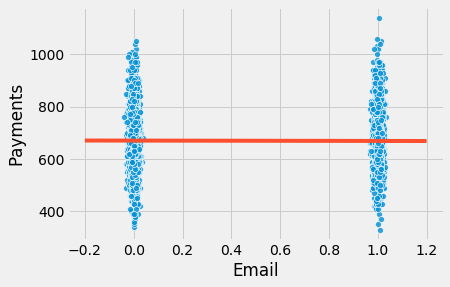

In [4]:
sns.scatterplot("email", "payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

我们可以看到单个治疗组中的付款差异有多大。从视觉上看，看起来两组都从400以下到1000。如果电子邮件的影响是5.00或10.00 R $，难怪很难在所有可变性中找到它。


幸运的是，回归可以帮助我们降低这种可变性。诀窍是使用其他控件。**如果变量是结果的良好预测因子，它将解释其许多差异**。如果风险和信用额度是付款的良好预测因素，我们可以控制它们，以便更容易地发现电子邮件对付款的影响。如果我们记得回归是如何工作的，这有一个直观的解释。向回归添加额外的变量意味着在查看治疗时保持它们不变。因此，推理是，如果我们看一下类似的风险水平和信用额度，响应变量"付款"的方差应该更小。或者，换句话说，如果风险和信用额度可以很好地预测付款，则具有相似风险和信用额度的客户也应该具有相似的付款水平，因此差异较小。

![img](./data/img/beyond-conf/y-pred.png)


为了证明这一点，让我们采用将回归分为2个步骤的偏出方式。首先，我们将在额外的控制，信用额度和风险评分上回归治疗，电子邮件，结果，付款。其次，我们将在步骤1中获得的付款剩余量上回归处理的剩余值。（这纯粹是教学法，在实践中你不需要经历所有的麻烦）。

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

这将降低因变量的方差。通过对信用额度和风险的回归支付并获得此模型的残差，我们正在创建一个新的因变量，其可变性比原始变量小得多。最后一个模型还发现了具有有效标准误差估计值的 ATE。

只是出于好奇，我们还可以检查预测治疗的模型不应该能够降低它的方差。这是因为电子邮件在设计上是随机的，所以没有什么可以预测它。

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.61241599994
Payments Residual Variance 5652.453558466197
Email Variance 0.24991536000001294
Email Residual Variance 0.24918421069820038


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.143e-13,1.063,3.9e-13,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


请注意付款的差异如何从 10807 变为 5652。一旦我们控制了风险和信用额度，我们已经将其降低了近一半。另请注意，我们没有设法减少治疗电子邮件的可变性。这是有道理的，因为风险和信用额度不能预测电子邮件（根据随机性的定义，什么都不可以预测）。

现在，我们看到一些更合理的东西。这一新的估计告诉我们，我们应该期望收到电子邮件的客户平均比对照组多支付4.4雷亚尔。现在，此估计值在统计上与零不同。我们还可以想象每个对照组中的方差现在如何降低。

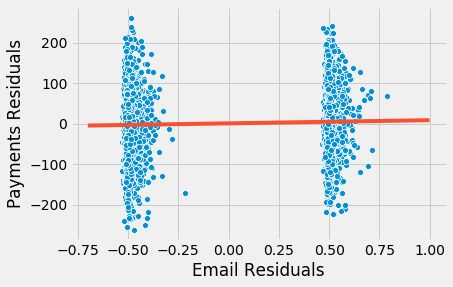

In [7]:
sns.scatterplot("res_email", "res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

正如我所说，我们这样做是出于教学原因。在实践中，您只需将控件与处理一起添加到回归模型中，估计值将完全相同。

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


总而言之，每当我们有一个控件可以很好地预测结果时，即使它不是混杂因素，将其添加到我们的模型中也是一个好主意。它有助于降低我们治疗效果估计的方差。这是一张因果图的情况图片。

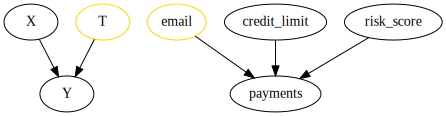

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## 主要是有害的对照

作为第二个启发用的示例，让我们考虑一个2家医院都在进行的药物测试场景。他们都在对一种治疗某种疾病的新药进行随机试验。感兴趣的结果是住院天数。如果治疗有效，它将减少患者在医院停留的天数。对于其中一家医院，有关随机治疗的策略是将其给予90%的患者，而10%的患者接受安慰剂。另一家医院有不同的策略：它随机给10%的患者提供药物，90%的患者服用安慰剂。您还被告知，提供90%的真正药物和10%安慰剂的医院通常会得到更严重的疾病病例进行治疗。

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


由于您正在处理随机数据，因此您的第一本能是简单地对治疗结果进行回归。

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


但是你会发现一些违反直觉的结果。治疗如何增加住院天数？答案在于我们正在运行2个不同的实验。严重程度与在医院的天数较多呈正相关，并且由于病例较重的医院也给予更多的药物，因此药物与在医院的天数呈正相关。当我们一起看两家医院时，我们有 \\(E[Y_0|T=0]>E[Y_0|T=1]\\) ，也就是说，平均而言，未治疗者的潜在结果高于接受治疗者，因为在病情较轻的医院中，未治疗的病例较多。换句话说，严重程度起到了混杂因素的作用，决定了患者去的医院，从而决定了接受药物的可能性。

有两种方法可以解决这个问题。第一个破坏了使用两家医院数据的目的，即简单地单独查看每家医院的ATE。

In [12]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [13]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


在本例中，我们确实得到了 ATE 的直观结果。看起来现在这种药物实际上正在降低在医院的天数。但是，由于我们单独查看每家医院，因此没有足够的数据点。因此，我们无法找到具有统计学意义的结果。

另一种利用回归功能的方法是通过将其包含在模型中来控制严重性。

In [14]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


接下来出现的问题是，我们是否也应该将医院纳入模型？毕竟，我们知道医院造成的治疗对吗？嗯，这是真的，但是一旦我们控制了严重程度，医院就不再与住院天数的结果相关。我们知道，要成为混杂因素，变量必须同时引起治疗和结果。在这种情况下，我们有一个仅导致治疗的变量。

但也许控制它会降低方差，对吧？好吧，又不是真的。为了使对照降低方差，它必须是结果的良好预测因子，而不是治疗的预测因子，这里的情况就是如此。

不过，我们可能想控制它吗？它不会伤害...还是可以？

In [15]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636
